In [26]:
import pandas as pd 
from glob import glob
import cv2
from inference import decode_rle_to_mask
from dataset import get_xray_classes
import numpy as np
import matplotlib.pyplot as plt
import utils

In [ ]:
# 시각화를 위한 팔레트를 설정합니다.
PALETTE = [
    (220, 20, 60), (119, 11, 32), (0, 0, 142), (0, 0, 230), (106, 0, 228),
    (0, 60, 100), (0, 80, 100), (0, 0, 70), (0, 0, 192), (250, 170, 30),
    (100, 170, 30), (220, 220, 0), (175, 116, 175), (250, 0, 30), (165, 42, 42),
    (255, 77, 255), (0, 226, 252), (182, 182, 255), (0, 82, 0), (120, 166, 157),
    (110, 76, 0), (174, 57, 255), (199, 100, 0), (72, 0, 118), (255, 179, 240),
    (0, 125, 92), (209, 0, 151), (188, 208, 182), (0, 220, 176),
]

# 시각화 함수입니다. 클래스가 2개 이상인 픽셀을 고려하지는 않습니다.
def label2rgb(label):
    image_size = label.shape[1:] + (3, )
    image = np.zeros(image_size, dtype=np.uint8)
    
    for i, class_label in enumerate(label):
        image[class_label == 1] = PALETTE[i]
        
    return image


def seach_matching_paths(image_name, paths):
    matching_paths = [path for path in paths if image_name in path]
    return matching_paths


def get_preds(image_name, df, classes):
    index = df['image_name'] == image_name
    preds = [[] for _ in range(classes['num_class'])] # 행렬 초기화

    for _, row in df[index].iterrows():
        c, rle = row['class'], row['rle']
        idx = classes['class2idx'][c]
        pred = decode_rle_to_mask(rle, height=2048, width=2048)
        preds[idx] = pred

    preds = np.stack(preds, 0)
    return preds
    

def color_norm(color):
    return [i/255. for i in color]

def plot_gt(anns_path, classes, ax, color=None):
    anns = utils.read_json(anns_path)['annotations']

    for ann in anns:
        class_name = ann["label"]
        class_ind = classes['class2idx'][class_name]
        points = np.array(ann["points"])

        if color is None:
            ax.plot(points[:, 0], points[:, 1], color=color_norm(PALETTE[class_ind]))
        else:
            ax.plot(points[:, 0], points[:, 1], color=color)


In [28]:
file_path = '/data/ephemeral/home/Dongjin/level2-cv-semanticsegmentation-cv-02-lv3/Baseline/Dongjin/transformers_1120/trained_models/cont/upernet-convnext-small_cont_size_1024_cont_weight/valid_ep_47_vdice_0.9716_upernet-convnext-small_cont_size_1024_cont_weight.csv'
data_dir_path = '/data/ephemeral/home/data'

df = pd.read_csv(file_path)
image_names = df['image_name'].unique()
image_paths = glob(data_dir_path + '/**/*.png', recursive=True)
anns_paths = glob(data_dir_path + '/**/*.json', recursive=True)
classes = get_xray_classes()

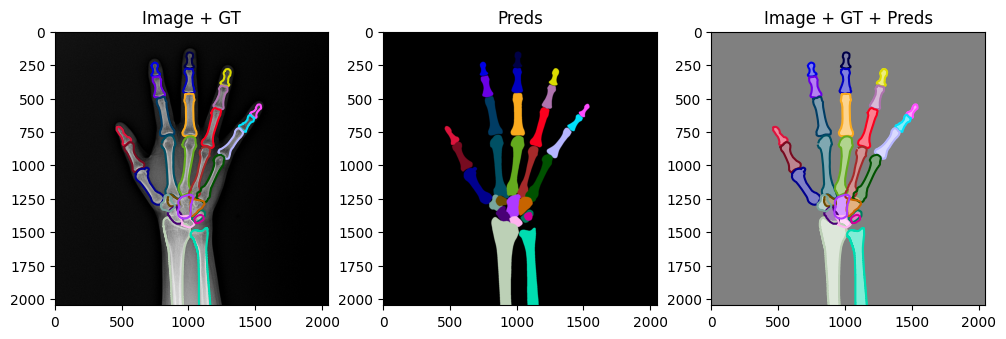

In [ ]:

for image_name in image_names:
    image_paths = seach_matching_paths(image_name, image_paths)
    anns_paths = seach_matching_paths(image_name, anns_paths)
    
    # 이름이 매칭되는 이미지 경로가 없거나 여러 가지이면 오류
    if len(image_paths) == 0:
        raise(Exception("Fail to find image"))
    elif 1 < len(image_paths):
        raise(Exception("Find images more than one"))
    # 이름이 매칭되는 GT가 여러 가지이면 오류
    if 1 < len(anns_paths):
        raise(Exception("Find annotations more than one"))
    
    # 이미지 불러오기
    image_path = image_paths[0] 
    image = cv2.imread(image_path)

    # 예측결과 불러오기
    preds = get_preds(image_name, df, classes)

    # GT 불러오기
    gt = None
    if len(anns_paths) == 1:
        anns_path = anns_paths[0]
        # gt = get_anns(annos_path)


    fig, axes = plt.subplots(1, 3, figsize=(12, 4))

    image_preds = label2rgb(preds)
    image_overlap = image + image_preds

    axes[0].imshow(image)
    axes[1].imshow(image_preds)
    axes[2].imshow(image, alpha=0.5)
    axes[2].imshow(image_preds, alpha=0.5)

    plot_gt(anns_path, classes, axes[0])
    plot_gt(anns_path, classes, axes[2])

    axes[0].set_title("Image + GT")
    axes[1].set_title("Preds")
    axes[2].set_title("Image + GT + Preds")
    break

    
    

278.4